# Voronoi Diagrams

## Introduction

A [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) is a visualisation of an area partitioned into regions that minimise the distance to given point locations. These diagrams are also known variously as Voronoi tessellations, Dirichlet tessellation and Thiessen polygons. [An example](https://commons.wikimedia.org/wiki/File:Euclidean_Voronoi_diagram.svg) is shown below.

<center><img src="../../data/img/Euclidean_Voronoi_diagram.png"width=400/>
[<a href="https://commons.wikimedia.org/wiki/File:Euclidean_Voronoi_diagram.svg" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/4.0/deed.en" target=_blank>License</a>]</center>   

Voronoi diagrams are constructed using a similar method to buffers around points (see [Operations notebook](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Operations.ipynb)), but ensure that there are no overlaps between polygons (see [Relations notebook](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Relations.ipynb)). Voronoi digrams are also useful for thinking about spatial neighbourhoods (as explored in the Spatial Weights notebook). There are numerous processes [Voronoi diagrams have been used to investigate](https://en.wikipedia.org/wiki/Voronoi_diagram#Applications).  

In this notebook we will see how to create Voronoi diagrams, using ['John Snow data'](https://github.com/jamesdamillington/john-snow) about the [1854 cholera outbreak in Soho](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak). Steven Johnson discusses how Snow used Voronoi diagrams himself, in the Conclusion chapter of his [book, _The Ghost Map_](https://en.wikipedia.org/wiki/The_Ghost_Map). 

We will use functions from [the PySAL library](https://pysal.org/libpysal/)  (more examples of use [here](https://pysal.org/libpysal/notebooks/voronoi.html)) 

## Setup

First, import the necessary packages. 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.cg.voronoi import voronoi, voronoi_frames
import numpy as np

**Note:** here were are importing `voronoi` and `voronoi_frames` functions from the `libpysal.cg` module. These are _different_ from the `Voronoi` function from `libpysal.weights` module (which we use in the Spatial Weights notebook).

Now, load data

In [2]:
# Load point data
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')
# Load building blocks
blocks = gpd.read_file('../../data/dani/polys.shp')

Quick look at the (small) `pumps` GeoDataFrame:

In [33]:
blocks.total_bounds

array([529139.3 , 180795.14, 529696.05, 181319.85])

In [3]:
pumps

,ID,x,y,name,geometry
0,1,529396.539395,181025.063047,Broad St Pump,POINT (529396.539 181025.063)
1,2,529192.537868,181079.391380,Great Malborough Pump,POINT (529192.538 181079.391)
2,3,529183.739766,181193.735013,Ramilies Place Pump,POINT (529183.740 181193.735)
3,5,529613.205238,180896.804121,Rupert St Pump,POINT (529613.205 180896.804)
4,6,529453.585995,180826.353152,Brewer St Pump,POINT (529453.586 180826.353)
5,8,529296.104419,180794.849037,Warwick St Pump,POINT (529296.104 180794.849)


And quickly plot the data to visualise what we are working with:
- blue points are locations of water pumps
- grey polygons are footprints of buildings. 

<AxesSubplot:>

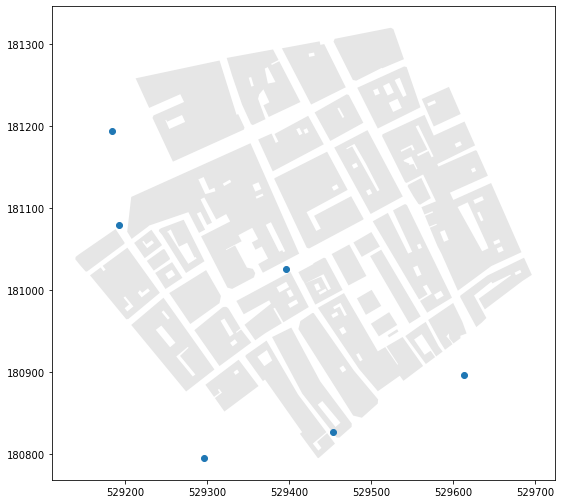

In [4]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax)

# Create Thiessen Polygons (for a Voronoi diagram)

The `voronoi` function in requires a [_nx2 array of points_](https://pysal.org/libpysal/_modules/libpysal/cg/voronoi.html). In plain language, this means the data to create the voronoi diagram need to be provided as a 2-dimensional ( _nx2_ ) table ( _array_ ) of coordinates for point locations ( _points_ ) in the form of a [numpy array](https://numpy.org/doc/stable/reference/arrays.ndarray.html). 

We can create a numpy array from our GeoDataFrame using [`np.vstack`](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html). For example:

In [5]:
points = np.vstack([pumps['x'], pumps['y']])

Let's check the type:

In [6]:
type(points)

numpy.ndarray

And as we have only five points, we can view them all

In [7]:
points

array([[529396.53939544, 529192.53786754, 529183.73976627,
        529613.20523815, 529453.5859949 , 529296.10441902],
       [181025.06304746, 181079.39137965, 181193.7350127 ,
        180896.8041212 , 180826.35315203, 180794.84903736]])

This is close to what we want, but rather than all the x co-ords in one column, and all the y co-ords in another, we want the co-ordinates grouped together. So get this, we need to [transpose](https://en.wikipedia.org/wiki/Transpose) the data. [This animated gif](https://commons.wikimedia.org/wiki/File:Matrix_transpose.gif) might help to visualise what a transposition does:  

<center><img src="../../data/img/Matrix_transpose.gif" width=150/></center>

We can transpose a `np.ndarray` using the `.T` [method](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html):

In [8]:
points = np.vstack([pumps['x'], pumps['y']]).T  

Look at the data and see how they co-ords are grouped differently:

In [9]:
points

array([[529396.53939544, 181025.06304746],
       [529192.53786754, 181079.39137965],
       [529183.73976627, 181193.7350127 ],
       [529613.20523815, 180896.8041212 ],
       [529453.5859949 , 180826.35315203],
       [529296.10441902, 180794.84903736]])

Now we're ready to create the voronoi:

In [10]:
results = voronoi(points)

The `voronoi` function returns a `tuple` of (`list`, `np.ndarray`):

In [11]:
type(results)

tuple

In [12]:
type(results[0])

list

In [13]:
type(results[1])

numpy.ndarray

In [14]:
results

([[4, 2, 1, 0, 3],
  [6, 2, 1, 5],
  [7, 1, 0, 8],
  [10, 9, 0, 3],
  [12, 11, 3, 4],
  [13, 14, 4, 2]],
 array([[ 530485.48740599,  182617.47165824],
        [ 529319.69417315,  181146.68564301],
        [ 529265.98390538,  180945.00493156],
        [ 529496.0908641 ,  180946.09921059],
        [ 529355.79616422,  180905.82272847],
        [-166260.98526651,  127625.65350865],
        [-126296.89568525,  -57664.07577014],
        [-166260.98526651,  127625.65350865],
        [ 927233.69731294,  756453.5461831 ],
        [ 927233.69731294,  756453.5461831 ],
        [ 811193.11719627, -457288.78533121],
        [ 811193.11719627, -457288.78533121],
        [ 666206.18883103, -503176.73991833],
        [-126296.89568525,  -57664.07577014],
        [ 666206.18883103, -503176.73991833]]))

To get the list and array in separate objects, we can return the `voronoi` function to two objects: 

In [15]:
regions, vertices = voronoi(points)

In [16]:
print(type(regions))
print(regions)

<class 'list'>
[[4, 2, 1, 0, 3], [6, 2, 1, 5], [7, 1, 0, 8], [10, 9, 0, 3], [12, 11, 3, 4], [13, 14, 4, 2]]


In [17]:
print(type(vertices))
print(vertices)

<class 'numpy.ndarray'>
[[ 530485.48740599  182617.47165824]
 [ 529319.69417315  181146.68564301]
 [ 529265.98390538  180945.00493156]
 [ 529496.0908641   180946.09921059]
 [ 529355.79616422  180905.82272847]
 [-166260.98526651  127625.65350865]
 [-126296.89568525  -57664.07577014]
 [-166260.98526651  127625.65350865]
 [ 927233.69731294  756453.5461831 ]
 [ 927233.69731294  756453.5461831 ]
 [ 811193.11719627 -457288.78533121]
 [ 811193.11719627 -457288.78533121]
 [ 666206.18883103 -503176.73991833]
 [-126296.89568525  -57664.07577014]
 [ 666206.18883103 -503176.73991833]]


We could also use the `voronoi_frames` function. This does excatly the same as `vornoi`, but returns a tuple of two `GeoDataFrame`s (assuming geopandas loaded):

In [18]:
results_df = voronoi_frames(points)

In [19]:
type(results_df)

tuple

In [20]:
type(results_df[0])

geopandas.geodataframe.GeoDataFrame

In [21]:
type(results_df[1])

geopandas.geodataframe.GeoDataFrame

In [22]:
regions_df, vertices_df = voronoi_frames(points)

In [23]:
regions_df

,geometry
0,"POLYGON ((529355.796 180905.823, 529265.984 18..."
1,"POLYGON ((529183.740 181136.225, 529319.694 18..."
2,"POLYGON ((529356.987 181193.735, 529319.694 18..."
3,"POLYGON ((529562.848 180794.849, 529496.091 18..."
4,"POLYGON ((529377.996 180794.849, 529355.796 18..."
5,"POLYGON ((529183.740 180915.070, 529265.984 18..."


In [24]:
vertices_df

,geometry
0,POINT (529396.539 181025.063)
1,POINT (529192.538 181079.391)
2,POINT (529183.740 181193.735)
3,POINT (529613.205 180896.804)
4,POINT (529453.586 180826.353)
5,POINT (529296.104 180794.849)


With the simple use of `voronoi` and `voronoi_frames` used above, the extent of the voronoi diagram is limited to the bounding box of the points used to create the diagram:

<AxesSubplot:>

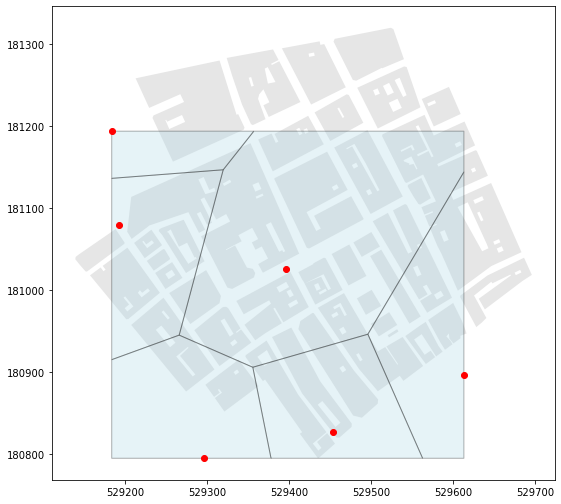

In [25]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
regions_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
vertices_df.plot(ax=ax, color='red')

If we wanted to create the diagram over a larger extent, we can provide a value to the `clip` argument to the `voronoi_frames`. For example, this could be a polygon object or we could specify no clipping whatsoever with _'none'_ : 

<AxesSubplot:>

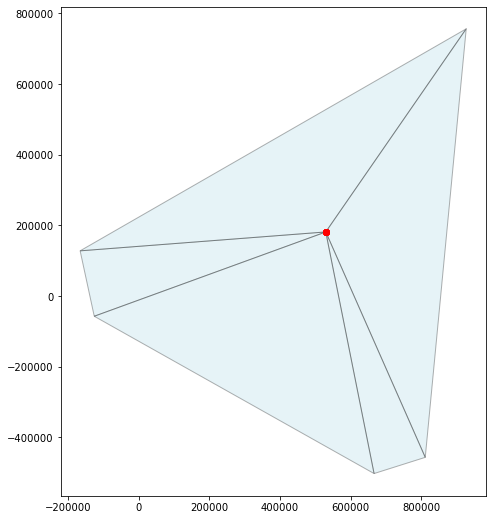

In [26]:
regions_df_noclip, vertices_df_noclip = voronoi_frames(points, clip='none')

f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
regions_df_noclip.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
vertices_df.plot(ax=ax, color='red')

# Plotting

If we specify no clipping, we could then visualise by specifying the limits of matplotlib axes. For example:

<AxesSubplot:>

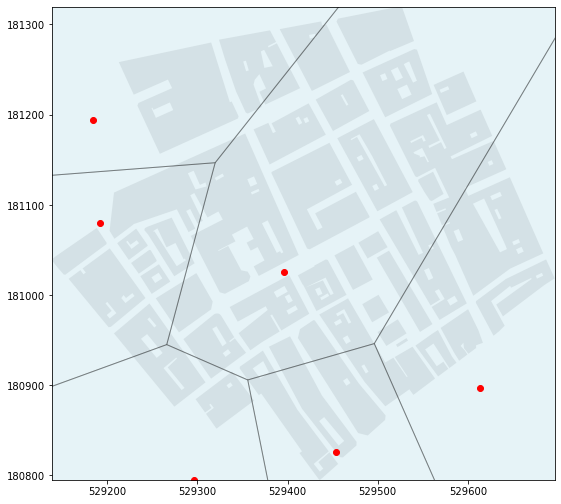

In [34]:
f, ax = plt.subplots(1, figsize=(9, 9))

ax.set_xlim(blocks.total_bounds[0],blocks.total_bounds[2])   #use bounding box of blocks
ax.set_ylim(blocks.total_bounds[1],blocks.total_bounds[3])   #use bounding box of blocks

blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
regions_df_noclip.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
vertices_df_noclip.plot(ax=ax, color='red')

We could also play with coloring the regions. 

To this, we would first add an ID column to use as a 'column' variable (like for a choropleth map):

In [35]:
regions_df_noclip['ID'] = range(0, len(regions_df_noclip))

Then, we need to re-set the geometry:

In [36]:
regions_df_noclip = regions_df_noclip.set_geometry('geometry')

Then we can plot using the _ID_ column to shade (using the _Set1_ colourmap):

<AxesSubplot:>

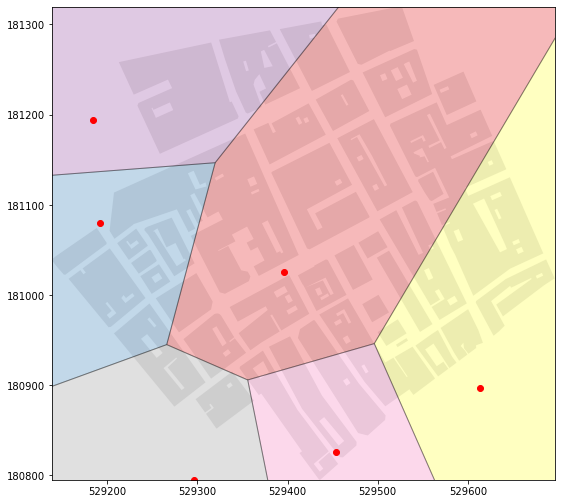

In [37]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.set_xlim(blocks.total_bounds[0],blocks.total_bounds[2])   #use bounding box of blocks
ax.set_ylim(blocks.total_bounds[1],blocks.total_bounds[3])   #use bounding box of blocks
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)

#use column here with a colourmap 
regions_df_noclip.plot(ax=ax, column='ID', cmap='Set1', edgecolor='black', alpha=0.3)
vertices_df_noclip.plot(ax=ax, color='red')

Think about how these regions are more or less useful than a simple (circular) buffer for understanding which pump people in Soho might have visited to get their water in 1854. 

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).